<a href="https://colab.research.google.com/github/efatmae/Andrej-Karpathy-advice-to-train-NN-in-practice/blob/main/setup_end_to_end_training_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook is an implementation attempt to reflect the first advice among 5 advices that Andrej Karpathy explanined in his post "A recipe for training neural networks." http://karpathy.github.io/2019/04/25/recipe/

##This is the second of a series of notebooks to follow these advices in practice. 

##sources: 

1.   https://gist.github.com/pgsrv/fdeea37fe316efa331334839d1028907
2.   https://github.com/howardyclo/papernotes/issues/56


### In this notebook we follow the following advices:
1. Establish baselines and visualize the train/eval metrics.
2. Fix random seed and run code twice to ensure to get the same results.
3. Disable any unnecessary fanciness, e.g., data augmentation.
4. Plot test losses of entire data instead of only batches.
5. Ensure the loss started with right value, e.g., -log(1/n_classes).
6. Visualize the fixed test batch to see the "dynamics" of how model learns (be aware of very low or very high learning rates).
7. Be aware of view and transpose/permute.
8. Write simple code that can work first and refactor to more generalizable version later.


In [ ]:
from keras.datasets import imdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow import keras
import nltk
#nltk.download('punkt')
import sys
import codecs
import nltk
from nltk.corpus import stopwords
from torch import nn
from sklearn.model_selection import *
from sklearn.linear_model import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, Flatten
from keras.models import Sequential
from sklearn.metrics import roc_auc_score,f1_score, log_loss
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [ ]:
batch_size, epochs, lr = 16, 10, 0.01

In [ ]:
## read IMDB data
data_df = pd.read_csv("Data/IMDB.csv", index_col=False)

In [ ]:
(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data(num_words=10000)
data = np.concatenate((training_data, testing_data), axis=0)
targets = np.concatenate((training_targets, testing_targets), axis=0)

/home/fatma/.local/lib/python3.6/site-packages/keras/datasets/imdb.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/fatma/.local/lib/python3.6/site-packages/keras/datasets/imdb.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [ ]:
seed = 42

X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.5, random_state=seed)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.5, random_state=seed)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
  # Tokenize and transform to integer index
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(data_df["data_text"])
vocab_size = len(tokenizer.word_index) + 1


In [ ]:
max_sequence_length = 1000
X_train = pad_sequences(X_train, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
X_valid = pad_sequences(X_valid, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
X_test = pad_sequences(X_test, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>

In [ ]:
X_train.shape

(12500, 10000)

In [ ]:
import keras 
from keras.regularizers import l1_l2

#reg = l1_l2(l2=0.00000001)

emb_model = Sequential()
emb_model.add(Embedding(vocab_size, 128, input_length=max_sequence_length))#, embeddings_regularizer=l1_l2(l2=1e-50
emb_model.add(Flatten())
emb_model.add(Dense(1, activation = 'sigmoid'))#W_regularizer=reg
#rmsprop
emb_model.compile(optimizer="sgd", loss='binary_crossentropy', metrics=METRICS)

training_history = emb_model.fit(
  X_train,
  y_train,
  epochs = 100,
    validation_data = [X_valid, y_valid]
)

Train on 12500 samples, validate on 12500 samples
Epoch 1/100
12500/12500 [==============================] - 14s 1ms/step - loss: 0.6999 - tp: 13915948.0000 - fp: 3766150.5000 - tn: 13159281.0000 - fn: 2835838.7500 - accuracy: 0.8039 - precision: 0.7870 - recall: 0.8307 - auc: 0.8913 - val_loss: 0.6924 - val_tp: 13917568.0000 - val_fp: 3767640.5000 - val_tn: 13164091.0000 - val_fn: 2840433.0000 - val_accuracy: 0.8038 - val_precision: 0.7870 - val_recall: 0.8305 - val_auc: 0.8912
Epoch 2/100
12500/12500 [==============================] - 12s 993us/step - loss: 0.6903 - tp: 13919999.0000 - fp: 3769648.0000 - tn: 13168352.0000 - fn: 2844237.5000 - accuracy: 0.8037 - precision: 0.7869 - recall: 0.8303 - auc: 0.8911 - val_loss: 0.6918 - val_tp: 13921884.0000 - val_fp: 3770764.5000 - val_tn: 13173541.0000 - val_fn: 2848532.2500 - val_accuracy: 0.8036 - val_precision: 0.7869 - val_recall: 0.8301 - val_auc: 0.8911
Epoch 3/100
12500/12500 [==============================] - 13s 1ms/step - loss: 

Epoch 20/100
12500/12500 [==============================] - 13s 1ms/step - loss: 0.5974 - tp: 14071892.0000 - fp: 3845572.5000 - tn: 13318605.0000 - fn: 2916151.7500 - accuracy: 0.8020 - precision: 0.7854 - recall: 0.8283 - auc: 0.8896 - val_loss: 0.6365 - val_tp: 14076472.0000 - val_fp: 3847631.0000 - val_tn: 13322846.0000 - val_fn: 2917774.7500 - val_accuracy: 0.8019 - val_precision: 0.7853 - val_recall: 0.8283 - val_auc: 0.8895
Epoch 21/100
12500/12500 [==============================] - 13s 1ms/step - loss: 0.5888 - tp: 14081088.0000 - fp: 3849648.0000 - tn: 13327127.0000 - fn: 2919372.5000 - accuracy: 0.8019 - precision: 0.7853 - recall: 0.8283 - auc: 0.8895 - val_loss: 0.6312 - val_tp: 14085848.0000 - val_fp: 3851783.5000 - val_tn: 13331252.0000 - val_fn: 2920839.2500 - val_accuracy: 0.8019 - val_precision: 0.7853 - val_recall: 0.8283 - val_auc: 0.8895
Epoch 22/100
12500/12500 [==============================] - 13s 1ms/step - loss: 0.5794 - tp: 14090617.0000 - fp: 3853908.7500 - t

Epoch 39/100
12500/12500 [==============================] - 13s 1ms/step - loss: 0.4330 - tp: 14255012.0000 - fp: 3910555.5000 - tn: 13492373.0000 - fn: 2969291.2500 - accuracy: 0.8013 - precision: 0.7847 - recall: 0.8276 - auc: 0.8887 - val_loss: 0.5243 - val_tp: 14260055.0000 - val_fp: 3911976.0000 - val_tn: 13497238.0000 - val_fn: 2970455.5000 - val_accuracy: 0.8013 - val_precision: 0.7847 - val_recall: 0.8276 - val_auc: 0.8887
Epoch 40/100
12500/12500 [==============================] - 13s 1ms/step - loss: 0.4252 - tp: 14265186.0000 - fp: 3913368.2500 - tn: 13502093.0000 - fn: 2971582.2500 - accuracy: 0.8013 - precision: 0.7847 - recall: 0.8276 - auc: 0.8887 - val_loss: 0.5194 - val_tp: 14270207.0000 - val_fp: 3914699.2500 - val_tn: 13507068.0000 - val_fn: 2972744.2500 - val_accuracy: 0.8013 - val_precision: 0.7847 - val_recall: 0.8276 - val_auc: 0.8887
Epoch 41/100
12500/12500 [==============================] - 12s 1000us/step - loss: 0.4176 - tp: 14275340.0000 - fp: 3916027.0000 

Epoch 58/100
12500/12500 [==============================] - 13s 1ms/step - loss: 0.3151 - tp: 14451843.0000 - fp: 3954895.0000 - tn: 13686755.0000 - fn: 3008732.0000 - accuracy: 0.8016 - precision: 0.7851 - recall: 0.8277 - auc: 0.8888 - val_loss: 0.4499 - val_tp: 14457132.0000 - val_fp: 3955881.5000 - val_tn: 13692060.0000 - val_fn: 3009644.7500 - val_accuracy: 0.8016 - val_precision: 0.7852 - val_recall: 0.8277 - val_auc: 0.8888
Epoch 59/100
12500/12500 [==============================] - 13s 1ms/step - loss: 0.3097 - tp: 14462468.0000 - fp: 3956850.2500 - tn: 13697349.0000 - fn: 3010548.0000 - accuracy: 0.8016 - precision: 0.7852 - recall: 0.8277 - auc: 0.8888 - val_loss: 0.4477 - val_tp: 14467727.0000 - val_fp: 3957805.5000 - val_tn: 13702704.0000 - val_fn: 3011487.7500 - val_accuracy: 0.8016 - val_precision: 0.7852 - val_recall: 0.8277 - val_auc: 0.8888
Epoch 60/100
12500/12500 [==============================] - 13s 1ms/step - loss: 0.3048 - tp: 14473051.0000 - fp: 3958745.2500 - t

Epoch 77/100
12500/12500 [==============================] - 13s 1ms/step - loss: 0.2399 - tp: 14656080.0000 - fp: 3990367.0000 - tn: 13890018.0000 - fn: 3040753.5000 - accuracy: 0.8023 - precision: 0.7860 - recall: 0.8282 - auc: 0.8893 - val_loss: 0.4208 - val_tp: 14661529.0000 - val_fp: 3991253.0000 - val_tn: 13895426.0000 - val_fn: 3041517.7500 - val_accuracy: 0.8024 - val_precision: 0.7860 - val_recall: 0.8282 - val_auc: 0.8894
Epoch 78/100
12500/12500 [==============================] - 13s 1ms/step - loss: 0.2363 - tp: 14667003.0000 - fp: 3992138.0000 - tn: 13900813.0000 - fn: 3042269.2500 - accuracy: 0.8024 - precision: 0.7860 - recall: 0.8282 - auc: 0.8894 - val_loss: 0.4208 - val_tp: 14672452.0000 - val_fp: 3993011.5000 - val_tn: 13906232.0000 - val_fn: 3043033.0000 - val_accuracy: 0.8024 - val_precision: 0.7861 - val_recall: 0.8282 - val_auc: 0.8894
Epoch 79/100
12500/12500 [==============================] - 13s 1ms/step - loss: 0.2337 - tp: 14677916.0000 - fp: 3993895.0000 - t

Epoch 96/100
12500/12500 [==============================] - 13s 1ms/step - loss: 0.1884 - tp: 14864236.0000 - fp: 4021800.5000 - tn: 14097323.0000 - fn: 3068858.5000 - accuracy: 0.8033 - precision: 0.7870 - recall: 0.8289 - auc: 0.8901 - val_loss: 0.4139 - val_tp: 14869736.0000 - val_fp: 4022589.5000 - val_tn: 14102823.0000 - val_fn: 3069572.0000 - val_accuracy: 0.8033 - val_precision: 0.7871 - val_recall: 0.8289 - val_auc: 0.8901
Epoch 97/100
12500/12500 [==============================] - 13s 1ms/step - loss: 0.1856 - tp: 14875262.0000 - fp: 4023359.5000 - tn: 14108328.0000 - fn: 3070279.2500 - accuracy: 0.8034 - precision: 0.7871 - recall: 0.8289 - auc: 0.8901 - val_loss: 0.4158 - val_tp: 14880752.0000 - val_fp: 4024136.0000 - val_tn: 14113842.0000 - val_fn: 3070997.2500 - val_accuracy: 0.8034 - val_precision: 0.7871 - val_recall: 0.8289 - val_auc: 0.8902
Epoch 98/100
12500/12500 [==============================] - 13s 1ms/step - loss: 0.1839 - tp: 14886280.0000 - fp: 4024918.5000 - t

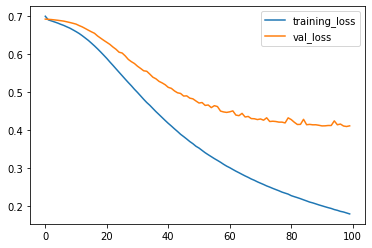

In [ ]:
import matplotlib.pyplot as plt
plt.plot(training_history.history["loss"], label="training_loss")
plt.plot(training_history.history["val_loss"], label="val_loss")
plt.legend()

In [ ]:
np.mean(training_history.history["loss"]), np.mean(training_history.history["val_loss"])

(0.3965594513476849, 0.514246604735756)

In [ ]:
X_valid.shape

(12500, 10000)

In [ ]:
train_loss = []
for i in range(0,X_train.shape[0]):
    prediction = emb_model.predict(X_train[i].reshape(1,10000))
    train_loss.append((y_train[i]-prediction[0][0])**2)

ValueError: cannot reshape array of size 10000 into shape (1,100)

In [ ]:
np.mean(train_loss)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(y_train.shape[0]),train_loss, label="train_loss")
plt.legend()

In [ ]:
evaluation_loss, evaluation_auc = [], []
for i in range(0,X_valid.shape[0]):
    prediction = emb_model.predict(X_valid[i].reshape(1,10000))
    evaluation_loss.append((y_valid[i]-prediction[0][0])**2)

In [ ]:
np.mean(evaluation_loss)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(y_valid.shape[0]),evaluation_loss, label="val_loss")
plt.legend()

In [ ]:
test_loss = []
for i in range(0,X_test.shape[0]):
    prediction = emb_model.predict(X_test[i].reshape(1,10000))
    test_loss.append((y_test[i]-prediction[0][0])**2)

In [ ]:
np.mean(test_loss)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(y_test.shape[0]),test_loss, label="test_loss")
plt.legend()

In [ ]:
emb_model.evaluate(X_test, y_test)

25000/25000 [==============================] - 11s 433us/step


[0.4073862804508209,
 14921521.0,
 4030394.5,
 14154625.0,
 3076946.5,
 0.8035638928413391,
 0.7873389720916748,
 0.8290432691574097,
 0.8902812600135803]

In [ ]:
predicted_labels = emb_model.predict(X_test)
print("AUC score", roc_auc_score(np.rint(y_test),predicted_labels))
    #auc.append(roc_auc_score(np.rint(y_val),predicted_labels))
print("F1 score", f1_score(np.rint(y_test),np.rint(predicted_labels)))


AUC score 0.8972991237683068
F1 score 0.8154223455152173


In [ ]:
log_loss(y_test, predicted_labels)

0.4073862849568817

## TF-idf vectorizer with keras 1 layer

In [ ]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range = (1,5))
vectorizer = vectorizer.fit(data_df["data_text"])

In [ ]:
seed = 42

X_train, X_test, y_train, y_test = train_test_split(data_df["data_text"], data_df["label"], test_size=0.5, random_state=seed)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.5, random_state=seed)

X_train = vectorizer.transform(X_train)
X_valid = vectorizer.transform(X_valid)
X_test = vectorizer.transform(X_test)


In [ ]:
import keras

model = Sequential()

model.add(Dense(1, activation='sigmoid', input_dim=X_train.shape[1]))
model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=METRICS)

training_history = model.fit(
  X_train,
  y_train,
  epochs = epochs,
    validation_data = [X_valid, y_valid]
)

Train on 12500 samples, validate on 12500 samples
Epoch 1/100
12500/12500 [==============================] - 3s 220us/step - loss: 0.6554 - tp: 4120308.0000 - fp: 1401985.1250 - tn: 3928177.0000 - fn: 1155803.5000 - accuracy: 0.7588 - precision: 0.7461 - recall: 0.7809 - auc: 0.8229 - val_loss: 0.6216 - val_tp: 4125291.7500 - val_fp: 1402923.7500 - val_tn: 3933535.5000 - val_fn: 1157020.8750 - val_accuracy: 0.7589 - val_precision: 0.7462 - val_recall: 0.7810 - val_auc: 0.8230
Epoch 2/100
12500/12500 [==============================] - 2s 151us/step - loss: 0.5880 - tp: 4130319.5000 - fp: 1403681.8750 - tn: 3939073.0000 - fn: 1158197.7500 - accuracy: 0.7590 - precision: 0.7464 - recall: 0.7810 - auc: 0.8231 - val_loss: 0.5660 - val_tp: 4135642.7500 - val_fp: 1404668.7500 - val_tn: 3944358.2500 - val_fn: 1159104.1250 - val_accuracy: 0.7591 - val_precision: 0.7465 - val_recall: 0.7811 - val_auc: 0.8232
Epoch 3/100
12500/12500 [==============================] - 2s 157us/step - loss: 0.5339 

Epoch 20/100
12500/12500 [==============================] - 2s 173us/step - loss: 0.2536 - tp: 4331355.5000 - fp: 1432069.1250 - tn: 4136833.0000 - fn: 1181015.3750 - accuracy: 0.7642 - precision: 0.7515 - recall: 0.7858 - auc: 0.8298 - val_loss: 0.3002 - val_tp: 4337003.5000 - val_fp: 1432737.2500 - val_tn: 4142459.7500 - val_fn: 1181571.8750 - val_accuracy: 0.7643 - val_precision: 0.7517 - val_recall: 0.7859 - val_auc: 0.8300
Epoch 21/100
12500/12500 [==============================] - 2s 179us/step - loss: 0.2481 - tp: 4342707.5000 - fp: 1433408.8750 - tn: 4148072.7500 - fn: 1182082.7500 - accuracy: 0.7645 - precision: 0.7518 - recall: 0.7860 - auc: 0.8302 - val_loss: 0.2966 - val_tp: 4348384.0000 - val_fp: 1434060.2500 - val_tn: 4153701.2500 - val_fn: 1182627.0000 - val_accuracy: 0.7647 - val_precision: 0.7520 - val_recall: 0.7862 - val_auc: 0.8304
Epoch 22/100
12500/12500 [==============================] - 2s 166us/step - loss: 0.2429 - tp: 4354052.5000 - fp: 1434712.3750 - tn: 415

Epoch 39/100
12500/12500 [==============================] - 2s 170us/step - loss: 0.1858 - tp: 4548620.0000 - fp: 1455272.6250 - tn: 4352388.0000 - fn: 1199992.0000 - accuracy: 0.7702 - precision: 0.7576 - recall: 0.7913 - auc: 0.8376 - val_loss: 0.2650 - val_tp: 4554376.0000 - val_fp: 1455832.2500 - val_tn: 4358100.0000 - val_fn: 1200465.6250 - val_accuracy: 0.7704 - val_precision: 0.7578 - val_recall: 0.7914 - val_auc: 0.8378
Epoch 40/100
12500/12500 [==============================] - 3s 211us/step - loss: 0.1836 - tp: 4560165.0000 - fp: 1456406.3750 - tn: 4363794.5000 - fn: 1200906.3750 - accuracy: 0.7706 - precision: 0.7579 - recall: 0.7915 - auc: 0.8380 - val_loss: 0.2642 - val_tp: 4565890.0000 - val_fp: 1456963.1250 - val_tn: 4369532.5000 - val_fn: 1201386.3750 - val_accuracy: 0.7707 - val_precision: 0.7581 - val_recall: 0.7917 - val_auc: 0.8382
Epoch 41/100
12500/12500 [==============================] - 2s 162us/step - loss: 0.1814 - tp: 4571658.0000 - fp: 1457530.6250 - tn: 437

Epoch 58/100
12500/12500 [==============================] - 2s 158us/step - loss: 0.1524 - tp: 4767518.0000 - fp: 1475486.6250 - tn: 4570889.0000 - fn: 1217378.5000 - accuracy: 0.7762 - precision: 0.7637 - recall: 0.7966 - auc: 0.8451 - val_loss: 0.2574 - val_tp: 4773264.5000 - val_fp: 1475991.6250 - val_tn: 4576673.5000 - val_fn: 1217841.2500 - val_accuracy: 0.7763 - val_precision: 0.7638 - val_recall: 0.7967 - val_auc: 0.8453
Epoch 59/100
12500/12500 [==============================] - 2s 173us/step - loss: 0.1511 - tp: 4779057.0000 - fp: 1476499.7500 - tn: 4582444.5000 - fn: 1218269.8750 - accuracy: 0.7765 - precision: 0.7640 - recall: 0.7969 - auc: 0.8455 - val_loss: 0.2573 - val_tp: 4784807.0000 - val_fp: 1477012.2500 - val_tn: 4588218.5000 - val_fn: 1218733.0000 - val_accuracy: 0.7766 - val_precision: 0.7641 - val_recall: 0.7970 - val_auc: 0.8457
Epoch 60/100
12500/12500 [==============================] - 2s 190us/step - loss: 0.1498 - tp: 4790590.5000 - fp: 1477517.3750 - tn: 459

Epoch 77/100
12500/12500 [==============================] - 2s 159us/step - loss: 0.1310 - tp: 4987081.5000 - fp: 1494522.0000 - tn: 4790590.5000 - fn: 1234079.2500 - accuracy: 0.7818 - precision: 0.7694 - recall: 0.8016 - auc: 0.8521 - val_loss: 0.2584 - val_tp: 4992854.0000 - val_fp: 1495022.6250 - val_tn: 4796378.0000 - val_fn: 1234516.5000 - val_accuracy: 0.7820 - val_precision: 0.7696 - val_recall: 0.8018 - val_auc: 0.8523
Epoch 78/100
12500/12500 [==============================] - 3s 219us/step - loss: 0.1301 - tp: 4998642.0000 - fp: 1495517.2500 - tn: 4802185.5000 - fn: 1234927.5000 - accuracy: 0.7821 - precision: 0.7697 - recall: 0.8019 - auc: 0.8525 - val_loss: 0.2586 - val_tp: 5004432.5000 - val_fp: 1496018.3750 - val_tn: 4807947.0000 - val_fn: 1235373.5000 - val_accuracy: 0.7823 - val_precision: 0.7699 - val_recall: 0.8020 - val_auc: 0.8527
Epoch 79/100
12500/12500 [==============================] - 2s 191us/step - loss: 0.1292 - tp: 5010216.5000 - fp: 1496512.0000 - tn: 481

Epoch 96/100
12500/12500 [==============================] - 2s 167us/step - loss: 0.1156 - tp: 5207202.0000 - fp: 1512879.7500 - tn: 5010957.0000 - fn: 1250231.2500 - accuracy: 0.7871 - precision: 0.7749 - recall: 0.8064 - auc: 0.8586 - val_loss: 0.2629 - val_tp: 5212966.0000 - val_fp: 1513352.0000 - val_tn: 5016783.0000 - val_fn: 1250669.0000 - val_accuracy: 0.7873 - val_precision: 0.7750 - val_recall: 0.8065 - val_auc: 0.8588
Epoch 97/100
12500/12500 [==============================] - 2s 189us/step - loss: 0.1150 - tp: 5218800.0000 - fp: 1513824.2500 - tn: 5022560.0000 - fn: 1251087.5000 - accuracy: 0.7874 - precision: 0.7752 - recall: 0.8066 - auc: 0.8589 - val_loss: 0.2632 - val_tp: 5224554.5000 - val_fp: 1514298.1250 - val_tn: 5028404.0000 - val_fn: 1251517.2500 - val_accuracy: 0.7876 - val_precision: 0.7753 - val_recall: 0.8067 - val_auc: 0.8591
Epoch 98/100
12500/12500 [==============================] - 2s 168us/step - loss: 0.1143 - tp: 5230378.5000 - fp: 1514766.7500 - tn: 503

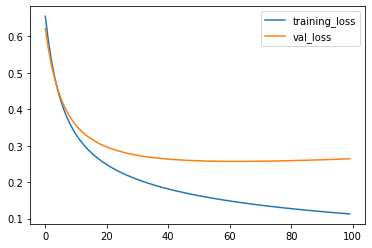

In [ ]:
import matplotlib.pyplot as plt
plt.plot(training_history.history["loss"], label="training_loss")
plt.plot(training_history.history["val_loss"], label="val_loss")
plt.legend()

In [ ]:
predicted_labels = model.predict(X_test)
print("AUC score", roc_auc_score(y_test,predicted_labels))
    #auc.append(roc_auc_score(np.rint(y_val),predicted_labels))
print("F1 score", f1_score(y_test,np.rint(predicted_labels)))


AUC score 0.9582411876417138
F1 score 0.8930638129211257


In [ ]:
log_loss(y_test, predicted_labels)

0.26528621184342877

In [ ]:
-np.log(1/2)

0.6931471805599453

In [ ]:
train_loss = []
for i in range(0,X_train.shape[0]):
    prediction = model.predict(X_train[i].reshape(1,10000))
    train_loss.append((y_train.values[i] - prediction[0][0])**2)

In [ ]:
np.mean(train_loss)

0.02880609133498875

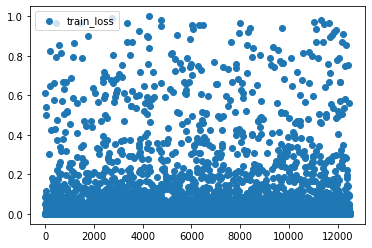

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(y_train.shape[0]),train_loss, label="train_loss")
plt.legend()

In [ ]:
valid_loss = []
for i in range(0,X_valid.shape[0]):
    prediction = model.predict(X_valid[i].reshape(1,10000))
    valid_loss.append((y_valid.values[i] - prediction[0][0])**2)

In [ ]:
np.mean(valid_loss)

0.07983643312673537

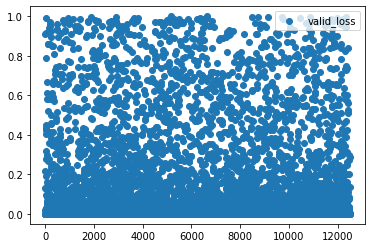

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(y_valid.shape[0]),valid_loss, label="valid_loss")
plt.legend()

In [ ]:
test_loss = []
for i in range(0,X_test.shape[0]):
    prediction = model.predict(X_test[i].reshape(1,10000))
    test_loss.append((y_test.values[i]-prediction[0][0])**2)

In [ ]:
np.mean(test_loss)

0.07929209730817767

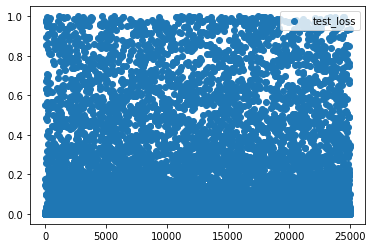

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(y_test.shape[0]),test_loss, label="test_loss")
plt.legend()

## Sklearn Logistic Regression model

In [ ]:


vectorizer = TfidfVectorizer(max_features=10000, ngram_range = (1,5))
vectorizer = vectorizer.fit(data_df["data_text"])

In [ ]:
seed = 42

X_train, X_test, y_train, y_test = train_test_split(data_df["data_text"], data_df["label"], test_size=0.5, random_state=seed)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.5, random_state=seed)

X_train = vectorizer.transform(X_train)
X_valid = vectorizer.transform(X_valid)
X_test = vectorizer.transform(X_test)


In [ ]:
X_train.shape

(12500, 10000)

In [ ]:
#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
#max_iterint, default=100

In [ ]:
sk_model = LogisticRegression() #(penalty="l1", C=10, solver='liblinear')
sk_model = sk_model.fit(X_train, y_train)

In [ ]:
predicted_labels = sk_model.predict(X_test)
print("AUC score", roc_auc_score(y_test,predicted_labels))
    #auc.append(roc_auc_score(np.rint(y_val),predicted_labels))
print("F1 score", f1_score(y_test,np.rint(predicted_labels)))


AUC score 0.8825943933523962
F1 score 0.8841872582300465


In [ ]:
predicted_prob = sk_model.predict_proba(X_test)
log_loss(y_test, predicted_prob)

0.3385778629471389